<a href="https://colab.research.google.com/github/hechen2020/BUS2070/blob/master/src/bus2070project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hechen2020/BUS2070.git

Cloning into 'BUS2070'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
cd ./BUS2070/src/

/content/BUS2070/src


In [0]:
import array
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.stats as ss

###European call pricing formula
$$C_0=S_0N(d_1)-Ke^{-rT}N(d_2)$$

where

$$d_1 = \frac{ln(S_0/K)+(r+\sigma^2/2)T}{\sigma \sqrt{T}}$$

$$d_2 = \frac{ln(S_0/K)+(r-\sigma^2/2)T}{\sigma \sqrt{T}} = d_1 - \sigma\sqrt{T}$$

In [0]:
'''=========
option class init
=========='''
class VanillaOption:
    def __init__(
        self,
        otype = 1, # 1: 'call'
                  # -1: 'put'
        strike = 110.,
        maturity = 1.,
        market_price = 10.):
      self.otype = otype
      self.strike = strike
      self.maturity = maturity
      self.market_price = market_price #this will be used for calibration
      
        
    def payoff(self, s): #s: excercise price
      otype = self.otype
      k = self.strike
      maturity = self.maturity
      return np.max([0, (s - k)*otype])

In [0]:
'''============
Gbm class inherited from sde_1d
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio

In [0]:
'''==============
below are from the market data for underlying asset
================='''
gbm1 = Gbm(
    init_state = 344.83, #market price for ULTA stock
    drift_ratio = 0.0260100, #3-month LIBOR rate as of April 12th
    vol_ratio = .2 #initial guess of volatility: this will change once we calculate implied volatility
)

In [0]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(gbm, vanilla_option):
    s0 = gbm.init_state
    sigma = gbm.vol_ratio
    r = gbm.drift_ratio
    
    otype = vanilla_option.otype
    k = vanilla_option.strike
    maturity = vanilla_option.maturity
    
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) 
          * maturity) / (sigma * np.sqrt(maturity))
    d2 = d1 - sigma * np.sqrt(maturity)
    
    return (otype * s0 * ss.norm.cdf(otype * d1)
            - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2))

In [0]:
'''==========
define a method for error function
============'''

def error_function(vol, gbm, option):
  gbm.vol_ratio = vol
  return np.abs(option.market_price - bsm_price(gbm, option))

'''==========
define a method to seek for an implied volatility by minimizing errors
============'''

def implied_volatility(gbm, option):
  init_vol = .2 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option), disp = 0)[0]

'''==========
define a method to seek for a calibrated volatility
============'''

def bsm_calibration(gbm, option_list):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, 
                 args = (gbm, option_list[i]), disp = 0)[0]

**First set of data: maturity on 04/18/2019**

In [9]:
'''=========
Time length: maturity time as a percentage of year
============='''
#record initial time t0
today = np.datetime64('2019-04-13')
#record maturity of the set of options
maturity = np.datetime64('2019-04-18')
#calculate the number of days to maturity
time_to_maturity_days = maturity - today
#calculate the maturity time as a percentage of year
time_to_maturity_years = time_to_maturity_days/np.timedelta64(1,'D')/365
print('--->>>>>time to maturity in years is ' + str(time_to_maturity_years))

--->>>>>time to maturity in years is 0.0136986301369863


In [10]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price

#call options
np_option_data1 = np.loadtxt('0418_data.dat', comments='#', delimiter=',')

print('>>>>>>option_type, maturity, strike, option_price')
print(np_option_data1)

>>>>>>option_type, maturity, strike, option_price
[[1.00000000e+00 1.36986301e-02 3.10000000e+02 3.99300000e+01]
 [1.00000000e+00 1.36986301e-02 3.15000000e+02 3.49000000e+01]
 [1.00000000e+00 1.36986301e-02 3.20000000e+02 2.50000000e+01]
 [1.00000000e+00 1.36986301e-02 3.22500000e+02 2.34000000e+01]
 [1.00000000e+00 1.36986301e-02 3.25000000e+02 2.32000000e+01]
 [1.00000000e+00 1.36986301e-02 3.27500000e+02 2.41000000e+01]
 [1.00000000e+00 1.36986301e-02 3.30000000e+02 1.69800000e+01]
 [1.00000000e+00 1.36986301e-02 3.32500000e+02 2.05000000e+01]
 [1.00000000e+00 1.36986301e-02 3.35000000e+02 1.34300000e+01]
 [1.00000000e+00 1.36986301e-02 3.40000000e+02 6.46000000e+00]
 [1.00000000e+00 1.36986301e-02 3.45000000e+02 3.43000000e+00]
 [1.00000000e+00 1.36986301e-02 3.50000000e+02 1.58000000e+00]
 [1.00000000e+00 1.36986301e-02 3.52500000e+02 1.05000000e+00]
 [1.00000000e+00 1.36986301e-02 3.55000000e+02 7.30000000e-01]
 [1.00000000e+00 1.36986301e-02 3.57500000e+02 3.40000000e-01]
 [1.0

In [0]:
num_row = np_option_data1.shape[0]
option_list1 = []

for i in range(num_row):
    optioni = VanillaOption(
        otype = np_option_data1[i,0],
        maturity = np_option_data1[i,1],
        strike = np_option_data1[i,2],
        market_price = np_option_data1[i,3]
    )
    option_list1.append(optioni)

In [12]:
#add a column to the matrix for option data in place for implied volatility
np_option_data12 = np.append(np_option_data1, np.zeros([num_row,1]), axis = 1)

#compute implied volatilities and add them into the last column
for i in range(num_row):
  np_option_data12[i,4] = implied_volatility(gbm1, option_list1[i])
  
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data12)

>>>>>>otype, maturity, strike, option_price, implied vol
[[1.00000000e+00 1.36986301e-02 3.10000000e+02 3.99300000e+01
  1.11816406e+00]
 [1.00000000e+00 1.36986301e-02 3.15000000e+02 3.49000000e+01
  1.01121094e+00]
 [1.00000000e+00 1.36986301e-02 3.20000000e+02 2.50000000e+01
  2.92031250e-01]
 [1.00000000e+00 1.36986301e-02 3.22500000e+02 2.34000000e+01
  4.66582031e-01]
 [1.00000000e+00 1.36986301e-02 3.25000000e+02 2.32000000e+01
  6.58925781e-01]
 [1.00000000e+00 1.36986301e-02 3.27500000e+02 2.41000000e+01
  8.69609375e-01]
 [1.00000000e+00 1.36986301e-02 3.30000000e+02 1.69800000e+01
  4.54453125e-01]
 [1.00000000e+00 1.36986301e-02 3.32500000e+02 2.05000000e+01
  8.45664063e-01]
 [1.00000000e+00 1.36986301e-02 3.35000000e+02 1.34300000e+01
  4.67558594e-01]
 [1.00000000e+00 1.36986301e-02 3.40000000e+02 6.46000000e+00
  2.14609375e-01]
 [1.00000000e+00 1.36986301e-02 3.45000000e+02 3.43000000e+00
  2.14472656e-01]
 [1.00000000e+00 1.36986301e-02 3.50000000e+02 1.58000000e+00
 

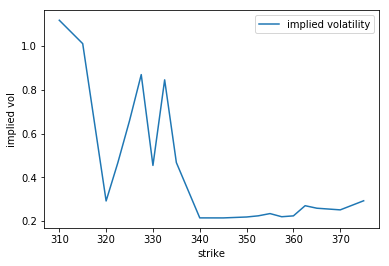

In [13]:
plt.plot(np_option_data12[:,2], np_option_data12[:,4], label = 'implied volatility')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend();

In [14]:
calibrated_volatility1 = bsm_calibration(gbm1,option_list1)
print('>>>>>>>> calibrated volatility for call is ' + str(calibrated_volatility1))

>>>>>>>> calibrated volatility for call is 0.29289062500000074


In [15]:
gbm1.vol_ratio = calibrated_volatility1

#find calibrated option price
option_list1_calibrated_price = [bsm_price(gbm1,option_list1[i]) for i in range(len(option_list1))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
option_list1_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[34.94325382974239,
 29.956310157340567,
 25.001170700225146,
 22.55187042948171,
 20.136870685736994,
 17.77313414218179,
 15.482076920799898,
 13.28888288760811,
 11.220980124168648,
 7.567836316602467,
 4.692420544207408,
 2.647550625904401,
 1.9146066708816107,
 1.34851126039338,
 0.9244774566690808,
 0.6165801656353906,
 0.3999187954316561,
 0.2521902509900862,
 0.09211096201555335,
 0.030031589785815438]

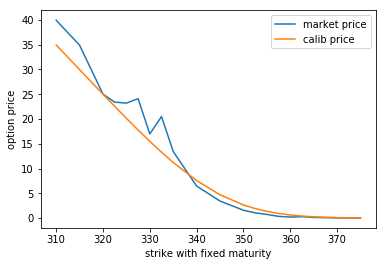

In [16]:
x_co = [option_list1[i].strike for i in range(len(option_list1))]
y_co = [option_list1[i].market_price for i in range(len(option_list1))]
plt.plot(x_co, y_co, label='market price')#not using 'o' here for observation purpose

y_co = option_list1_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed maturity')
plt.legend();

**Second set of data: maturity on 04/26/2019**

In [17]:
'''=========
Time length: maturity time as a percentage of year
============='''
#record initial time t0
today = np.datetime64('2019-04-13')
#record maturity of the set of options
maturity = np.datetime64('2019-04-26')
#calculate the number of days to maturity
time_to_maturity_days = maturity - today
#calculate the maturity time as a percentage of year
time_to_maturity_years = time_to_maturity_days/np.timedelta64(1,'D')/365
print('--->>>>>time to maturity in years is ' + str(time_to_maturity_years))

--->>>>>time to maturity in years is 0.03561643835616438


In [18]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price

#call options
np_option_data2 = np.loadtxt('0426_data.dat', comments='#', delimiter=',')

print('>>>>>>option_type, maturity, strike, option_price')
print(np_option_data2)

>>>>>>option_type, maturity, strike, option_price
[[1.00000000e+00 3.56164384e-02 3.20000000e+02 1.89000000e+01]
 [1.00000000e+00 3.56164384e-02 3.22500000e+02 2.83000000e+01]
 [1.00000000e+00 3.56164384e-02 3.25000000e+02 2.17600000e+01]
 [1.00000000e+00 3.56164384e-02 3.27500000e+02 9.30000000e+00]
 [1.00000000e+00 3.56164384e-02 3.30000000e+02 2.02000000e+01]
 [1.00000000e+00 3.56164384e-02 3.32500000e+02 1.74000000e+01]
 [1.00000000e+00 3.56164384e-02 3.35000000e+02 1.42000000e+01]
 [1.00000000e+00 3.56164384e-02 3.37500000e+02 1.28800000e+01]
 [1.00000000e+00 3.56164384e-02 3.40000000e+02 8.90000000e+00]
 [1.00000000e+00 3.56164384e-02 3.42500000e+02 7.30000000e+00]
 [1.00000000e+00 3.56164384e-02 3.45000000e+02 7.20000000e+00]
 [1.00000000e+00 3.56164384e-02 3.47500000e+02 4.50000000e+00]
 [1.00000000e+00 3.56164384e-02 3.50000000e+02 3.43000000e+00]
 [1.00000000e+00 3.56164384e-02 3.52500000e+02 2.72000000e+00]
 [1.00000000e+00 3.56164384e-02 3.55000000e+02 1.90000000e+00]
 [1.0

In [0]:
num_row = np_option_data2.shape[0]
option_list2 = []

for i in range(num_row):
    optioni = VanillaOption(
        otype = np_option_data2[i,0],
        maturity = np_option_data2[i,1],
        strike = np_option_data2[i,2],
        market_price = np_option_data2[i,3]
    )
    option_list2.append(optioni)

In [20]:
#add a column to the matrix for option data in place for implied volatility
np_option_data22 = np.append(np_option_data2, np.zeros([num_row,1]), axis = 1)

#compute implied volatilities and add them into the last column
for i in range(num_row):
  np_option_data22[i,4] = implied_volatility(gbm1, option_list2[i])
  
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data22)

>>>>>>otype, maturity, strike, option_price, implied vol
[[1.00000000e+00 3.56164384e-02 3.20000000e+02 1.89000000e+01
  2.00000000e-02]
 [1.00000000e+00 3.56164384e-02 3.22500000e+02 2.83000000e+01
  5.66425781e-01]
 [1.00000000e+00 3.56164384e-02 3.25000000e+02 2.17600000e+01
  3.15625000e-01]
 [1.00000000e+00 3.56164384e-02 3.27500000e+02 9.30000000e+00
  2.00000000e-02]
 [1.00000000e+00 3.56164384e-02 3.30000000e+02 2.02000000e+01
  4.34101563e-01]
 [1.00000000e+00 3.56164384e-02 3.32500000e+02 1.74000000e+01
  3.85195313e-01]
 [1.00000000e+00 3.56164384e-02 3.35000000e+02 1.42000000e+01
  3.18496094e-01]
 [1.00000000e+00 3.56164384e-02 3.37500000e+02 1.28800000e+01
  3.31870117e-01]
 [1.00000000e+00 3.56164384e-02 3.40000000e+02 8.90000000e+00
  2.32031250e-01]
 [1.00000000e+00 3.56164384e-02 3.42500000e+02 7.30000000e+00
  2.27451172e-01]
 [1.00000000e+00 3.56164384e-02 3.45000000e+02 7.20000000e+00
  2.74531250e-01]
 [1.00000000e+00 3.56164384e-02 3.47500000e+02 4.50000000e+00
 

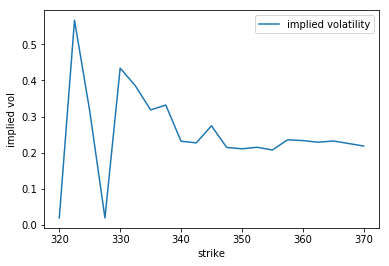

In [21]:
plt.plot(np_option_data22[:,2], np_option_data22[:,4], label = 'implied volatility')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend();

In [22]:
calibrated_volatility2 = bsm_calibration(gbm1,option_list2)
print('>>>>>>>> calibrated volatility for call is ' + str(calibrated_volatility2))

>>>>>>>> calibrated volatility for call is 0.21875000000000042


In [23]:
gbm1.vol_ratio = calibrated_volatility2

#find calibrated option price
option_list2_calibrated_price = [bsm_price(gbm1,option_list2[i]) for i in range(len(option_list2))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
option_list2_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[25.306448025617442,
 22.916576590658792,
 20.57700563328416,
 18.303777008924897,
 16.114915521702358,
 14.029584816440206,
 12.06694704021487,
 10.244834580993256,
 8.578389261051342,
 7.078845525300778,
 5.7526225899572125,
 4.600847341984007,
 3.619363965753024,
 2.7992120947502315,
 2.127488337641168,
 1.588459106467397,
 1.1647728230636858,
 0.8386270555006661,
 0.5927753434636998,
 0.28012379325149794]

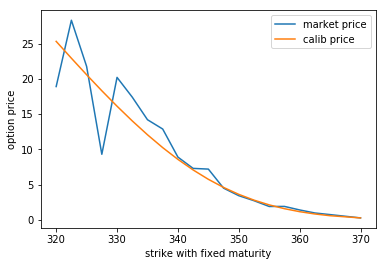

In [24]:
x_co = [option_list2[i].strike for i in range(len(option_list2))]
y_co = [option_list2[i].market_price for i in range(len(option_list2))]
plt.plot(x_co, y_co, label='market price')#not using 'o' here for observation purpose

y_co = option_list2_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed maturity')
plt.legend();

**Third set of data: maturity on 05/03/2019**

In [25]:
'''=========
Time length: maturity time as a percentage of year
============='''
#record initial time t0
today = np.datetime64('2019-04-13')
#record maturity of the set of options
maturity = np.datetime64('2019-05-03')
#calculate the number of days to maturity
time_to_maturity_days = maturity - today
#calculate the maturity time as a percentage of year
time_to_maturity_years = time_to_maturity_days/np.timedelta64(1,'D')/365
print('--->>>>>time to maturity in years is ' + str(time_to_maturity_years))

--->>>>>time to maturity in years is 0.0547945205479452


In [26]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price

#call options
np_option_data3 = np.loadtxt('0503_data.dat', comments='#', delimiter=',')

print('>>>>>>option_type, maturity, strike, option_price')
print(np_option_data3)

>>>>>>option_type, maturity, strike, option_price
[[1.00000000e+00 5.47945205e-02 3.22500000e+02 2.91000000e+01]
 [1.00000000e+00 5.47945205e-02 3.27500000e+02 1.72500000e+01]
 [1.00000000e+00 5.47945205e-02 3.32500000e+02 2.15000000e+01]
 [1.00000000e+00 5.47945205e-02 3.35000000e+02 1.60000000e+01]
 [1.00000000e+00 5.47945205e-02 3.37500000e+02 9.50000000e+00]
 [1.00000000e+00 5.47945205e-02 3.40000000e+02 1.56500000e+01]
 [1.00000000e+00 5.47945205e-02 3.42500000e+02 1.12000000e+01]
 [1.00000000e+00 5.47945205e-02 3.45000000e+02 8.10000000e+00]
 [1.00000000e+00 5.47945205e-02 3.47500000e+02 7.30000000e+00]
 [1.00000000e+00 5.47945205e-02 3.52500000e+02 4.00000000e+00]
 [1.00000000e+00 5.47945205e-02 3.57500000e+02 3.16000000e+00]
 [1.00000000e+00 5.47945205e-02 3.60000000e+02 6.20000000e+00]
 [1.00000000e+00 5.47945205e-02 3.62500000e+02 2.75000000e+00]
 [1.00000000e+00 5.47945205e-02 3.65000000e+02 1.65000000e+00]]


In [0]:
num_row = np_option_data3.shape[0]
option_list3 = []

for i in range(num_row):
    optioni = VanillaOption(
        otype = np_option_data3[i,0],
        maturity = np_option_data3[i,1],
        strike = np_option_data3[i,2],
        market_price = np_option_data3[i,3]
    )
    option_list3.append(optioni)

In [28]:
#add a column to the matrix for option data in place for implied volatility
np_option_data32 = np.append(np_option_data3, np.zeros([num_row,1]), axis = 1)

#compute implied volatilities and add them into the last column
for i in range(num_row):
  np_option_data32[i,4] = implied_volatility(gbm1, option_list3[i])
  
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data32)

>>>>>>otype, maturity, strike, option_price, implied vol
[[1.00000000e+00 5.47945205e-02 3.22500000e+02 2.91000000e+01
  4.83383789e-01]
 [1.00000000e+00 5.47945205e-02 3.27500000e+02 1.72500000e+01
  2.00000000e-02]
 [1.00000000e+00 5.47945205e-02 3.32500000e+02 2.15000000e+01
  4.49208984e-01]
 [1.00000000e+00 5.47945205e-02 3.35000000e+02 1.60000000e+01
  3.15786133e-01]
 [1.00000000e+00 5.47945205e-02 3.37500000e+02 9.50000000e+00
  1.43613281e-01]
 [1.00000000e+00 5.47945205e-02 3.40000000e+02 1.56500000e+01
  4.01298828e-01]
 [1.00000000e+00 5.47945205e-02 3.42500000e+02 1.12000000e+01
  3.03339844e-01]
 [1.00000000e+00 5.47945205e-02 3.45000000e+02 8.10000000e+00
  2.46660156e-01]
 [1.00000000e+00 5.47945205e-02 3.47500000e+02 7.30000000e+00
  2.58300781e-01]
 [1.00000000e+00 5.47945205e-02 3.52500000e+02 4.00000000e+00
  2.15439453e-01]
 [1.00000000e+00 5.47945205e-02 3.57500000e+02 3.16000000e+00
  2.37275391e-01]
 [1.00000000e+00 5.47945205e-02 3.60000000e+02 6.20000000e+00
 

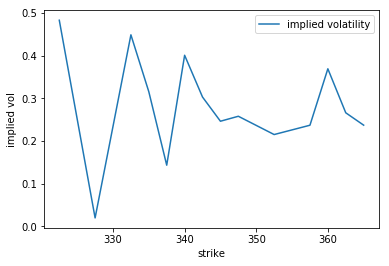

In [29]:
plt.plot(np_option_data32[:,2], np_option_data32[:,4], label = 'implied volatility')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend();

In [30]:
calibrated_volatility3 = bsm_calibration(gbm1,option_list3)
print('>>>>>>>> calibrated volatility for call is ' + str(calibrated_volatility3))

>>>>>>>> calibrated volatility for call is 0.2374218750000005


In [31]:
gbm1.vol_ratio = calibrated_volatility3

#find calibrated option price
option_list3_calibrated_price = [bsm_price(gbm1,option_list3[i]) for i in range(len(option_list3))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
option_list3_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[23.76520336059872,
 19.4937853899508,
 15.578222272249207,
 13.778885609816484,
 12.096334202818866,
 10.536902347139744,
 9.104948155597441,
 7.802675730475613,
 6.630069482144961,
 4.663088567971911,
 3.163820476162968,
 2.570409237892008,
 2.069000756595372,
 1.6499206481664004]

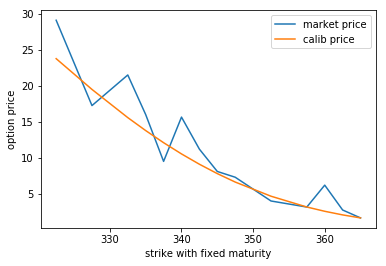

In [32]:
x_co = [option_list3[i].strike for i in range(len(option_list3))]
y_co = [option_list3[i].market_price for i in range(len(option_list3))]
plt.plot(x_co, y_co, label='market price')#not using 'o' here for observation purpose

y_co = option_list3_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed maturity')
plt.legend();

**Forth set of data: maturity on 05/17/2019**

In [33]:
'''=========
Time length: maturity time as a percentage of year
============='''
#record initial time t0
today = np.datetime64('2019-04-13')
#record maturity of the set of options
maturity = np.datetime64('2019-05-17')
#calculate the number of days to maturity
time_to_maturity_days = maturity - today
#calculate the maturity time as a percentage of year
time_to_maturity_years = time_to_maturity_days/np.timedelta64(1,'D')/365
print('--->>>>>time to maturity in years is ' + str(time_to_maturity_years))

--->>>>>time to maturity in years is 0.09315068493150686


In [34]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price

#call options
np_option_data4 = np.loadtxt('0517_data.dat', comments='#', delimiter=',')

print('>>>>>>option_type, maturity, strike, option_price')
print(np_option_data4)

>>>>>>option_type, maturity, strike, option_price
[[1.00000000e+00 9.31506849e-02 2.90000000e+02 4.54100000e+01]
 [1.00000000e+00 9.31506849e-02 2.95000000e+02 4.17000000e+01]
 [1.00000000e+00 9.31506849e-02 3.00000000e+02 5.00000000e+01]
 [1.00000000e+00 9.31506849e-02 3.10000000e+02 4.10000000e+01]
 [1.00000000e+00 9.31506849e-02 3.15000000e+02 3.41000000e+01]
 [1.00000000e+00 9.31506849e-02 3.20000000e+02 3.11000000e+01]
 [1.00000000e+00 9.31506849e-02 3.25000000e+02 2.75000000e+01]
 [1.00000000e+00 9.31506849e-02 3.30000000e+02 2.36000000e+01]
 [1.00000000e+00 9.31506849e-02 3.35000000e+02 2.21800000e+01]
 [1.00000000e+00 9.31506849e-02 3.40000000e+02 1.51000000e+01]
 [1.00000000e+00 9.31506849e-02 3.45000000e+02 9.80000000e+00]
 [1.00000000e+00 9.31506849e-02 3.60000000e+02 3.85000000e+00]
 [1.00000000e+00 9.31506849e-02 3.65000000e+02 2.65000000e+00]
 [1.00000000e+00 9.31506849e-02 3.70000000e+02 2.12000000e+00]
 [1.00000000e+00 9.31506849e-02 3.75000000e+02 1.20000000e+00]
 [1.0

In [0]:
num_row = np_option_data4.shape[0]
option_list4 = []

for i in range(num_row):
    optioni = VanillaOption(
        otype = np_option_data4[i,0],
        maturity = np_option_data4[i,1],
        strike = np_option_data4[i,2],
        market_price = np_option_data4[i,3]
    )
    option_list4.append(optioni)

In [36]:
#add a column to the matrix for option data in place for implied volatility
np_option_data42 = np.append(np_option_data4, np.zeros([num_row,1]), axis = 1)

#compute implied volatilities and add them into the last column
for i in range(num_row):
  np_option_data42[i,4] = implied_volatility(gbm1, option_list4[i])
  
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data42)

>>>>>>otype, maturity, strike, option_price, implied vol
[[1.00000000e+00 9.31506849e-02 2.90000000e+02 4.54100000e+01
  6.00000000e-02]
 [1.00000000e+00 9.31506849e-02 2.95000000e+02 4.17000000e+01
  6.00000000e-02]
 [1.00000000e+00 9.31506849e-02 3.00000000e+02 5.00000000e+01
  4.91328125e-01]
 [1.00000000e+00 9.31506849e-02 3.10000000e+02 4.10000000e+01
  4.48916016e-01]
 [1.00000000e+00 9.31506849e-02 3.15000000e+02 3.41000000e+01
  3.41855469e-01]
 [1.00000000e+00 9.31506849e-02 3.20000000e+02 3.11000000e+01
  3.69799805e-01]
 [1.00000000e+00 9.31506849e-02 3.25000000e+02 2.75000000e+01
  3.68339844e-01]
 [1.00000000e+00 9.31506849e-02 3.30000000e+02 2.36000000e+01
  3.52670898e-01]
 [1.00000000e+00 9.31506849e-02 3.35000000e+02 2.21800000e+01
  3.94824219e-01]
 [1.00000000e+00 9.31506849e-02 3.40000000e+02 1.51000000e+01
  2.89794922e-01]
 [1.00000000e+00 9.31506849e-02 3.45000000e+02 9.80000000e+00
  2.25703125e-01]
 [1.00000000e+00 9.31506849e-02 3.60000000e+02 3.85000000e+00
 

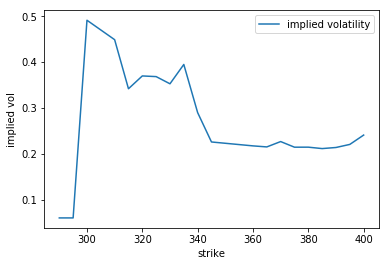

In [37]:
plt.plot(np_option_data42[:,2], np_option_data42[:,4], label = 'implied volatility')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend();

In [38]:
calibrated_volatility4 = bsm_calibration(gbm1,option_list4)
print('>>>>>>>> calibrated volatility for call is ' + str(calibrated_volatility4))

>>>>>>>> calibrated volatility for call is 0.24078125000000047


In [39]:
gbm1.vol_ratio = calibrated_volatility4

#find calibrated option price
option_list4_calibrated_price = [bsm_price(gbm1,option_list4[i]) for i in range(len(option_list4))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
option_list4_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[55.59692565709986,
 50.6730695329685,
 45.79836622814514,
 36.31264181925894,
 31.77965949807907,
 27.4492257415165,
 23.371859657253566,
 19.59589524728355,
 16.162832402585195,
 13.103168297430756,
 10.433423845223302,
 4.7042425363611216,
 3.4702144144711298,
 2.510226239968425,
 1.7805999355578663,
 1.2386837572060614,
 0.8452206786651928,
 0.5658439169958882,
 0.37176037095449743,
 0.2397784574833821]

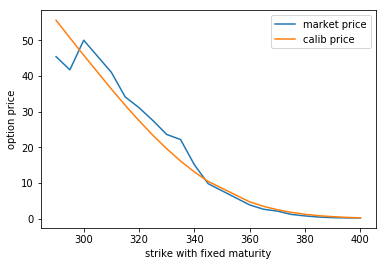

In [40]:
x_co = [option_list4[i].strike for i in range(len(option_list4))]
y_co = [option_list4[i].market_price for i in range(len(option_list4))]
plt.plot(x_co, y_co, label='market price')#not using 'o' here for observation purpose

y_co = option_list4_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed maturity')
plt.legend();